In [1]:
from __future__ import division
from pyoperators import pcg
from pysimulators import profile

# QUBIC packages
import qubic
from qubicpack.utilities import Qubic_DataDir
from qubic.data import PATH
from qubic.io import read_map
from qubic import QubicSkySim as qss
import sys
sys.path.append('/Users/mregnier/Desktop/PhD Regnier/mypackages')


import frequency_acquisition as Acq

# Display packages
import healpy as hp
import matplotlib.pyplot as plt

# FG-Buster packages
import component_model as c
import mixing_matrix as mm

# General packages
import numpy as np
import pysm3
import warnings
from qubic import QubicSkySim as qss
import pysm3.units as u
from importlib import reload
from pysm3 import utils

from qubic import SpectroImLib as sp
from importlib import reload
import gc
import copy
from pyoperators import *
import mypcg


# PyOperators packages
from pyoperators import (
    BlockColumnOperator, BlockDiagonalOperator, BlockRowOperator,
    CompositionOperator, DiagonalOperator, I, IdentityOperator,
    MPIDistributionIdentityOperator, MPI, proxy_group, ReshapeOperator,
    rule_manager, pcg, Operator)

from pysimulators.interfaces.healpy import HealpixConvolutionGaussianOperator
warnings.filterwarnings("ignore")
# %matplotlib inline

## Now QUBIC and Planck acquisitions used for reconstruction

def integration(nu_min, nu_max, Nintegr, sky_config, d, fwhm_subbands = None):
    print(f'Integration from {nu_min:.2f} to {nu_max:.2f} GHz with {Nintegr} steps')
    obj = Acq.QubicIntegrated(d, Nsub=Nintegr, Nrec=Nintegr)
    if Nintegr == 1:
        allnus = np.array([np.mean([nu_min, nu_max])])
    else:
        allnus = np.linspace(nu_min, nu_max, Nintegr)
    m = obj.get_PySM_maps(sky_config, nus=allnus)
    
    if fwhm_subbands is not None:
        for i in range(Nintegr):
            C = HealpixConvolutionGaussianOperator(fwhm=fwhm_subbands[i])
            m[i] = C(m[i])
    
    return np.array([np.mean(m, axis=0)])


# # %config InlineBackend.figure_format='retina'
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))


reload(Acq)
nside = 256
relative_bandwidth = 0.25
band = 220
band_planck = 217
seed = 42
noiseless = False
effective_duration = 3e0
rwplanck = 1.
tol = 1e-40
noise_planck_level = 0
noise_qubic_level = 0

def get_dictionary(nsub, nside, pointing, band):
    dictfilename = 'dicts/pipeline_demo.dict'
    
    # Read dictionary chosen
    d = qubic.qubicdict.qubicDict()
    d.read_from_file(dictfilename)
    d['nf_recon'] = nsub
    d['nf_sub'] = nsub
    d['nside'] = nside
    d['RA_center'] = 0
    d['DEC_center'] = -57
    center = qubic.equ2gal(d['RA_center'], d['DEC_center'])
    d['effective_duration'] = 3
    d['npointings'] = pointing
    d['filter_nu'] = int(band*1e9)
    d['photon_noise'] = False
    d['noiseless'] = False
    d['config'] = 'FI'
    d['MultiBand'] = True
    
    return d, center

/Users/mregnier/Desktop/PhD Regnier/mypackages/


/Users/mregnier/Desktop/PhD Regnier/mypackages/


In [2]:
nsub = 3
nside = 256
pointing = 1000
band = 150
d150, center = get_dictionary(nsub, nside, pointing, 150)
d220, _ = get_dictionary(nsub, nside, pointing, 220)

In [81]:
reload(Acq)

fact_sub = 1
Nrec = 1
Nsub = fact_sub * Nrec

qubic150 = Acq.QubicIntegrated(d150, Nsub=Nsub, Nrec=Nrec)
qubic220 = Acq.QubicIntegrated(d220, Nsub=Nsub, Nrec=Nrec)

/Users/mregnier/Desktop/PhD Regnier/mypackages/
You asked 1000 pointings with repeat strategy so I will provide 333 pointings repeated 3 times.
You asked 1000 pointings with repeat strategy so I will provide 333 pointings repeated 3 times.


In [82]:
qu = Acq.QubicTwoBands(qubic150, qubic220)
planck143 = Acq.PlanckAcquisition(143, qu.scene)
planck217 = Acq.PlanckAcquisition(217, qu.scene)

qupl = Acq.QubicPlanckMultiBandAcquisition(qu, [planck143, planck217])

#Hw = qu.get_operator(convolution=False)
#print(Hw.shapein, Hw.shapeout)

In [83]:
#H = qu.get_operator(convolution=False)

In [84]:
#H.operands[1].operands[1]#.operands[1]

In [85]:
invN = qupl.get_invntt_operator()

In [86]:
Hw_pl = qupl.get_operator()

Info apcmc2201.local: Allocating (991008,9) elements = 136.09423828125 MiB in FSRRotation3dMatrix.__init__.
Making sum from 131.25 to 168.75
Info apcmc2201.local: Allocating (991008,9) elements = 136.09423828125 MiB in FSRRotation3dMatrix.__init__.
Making sum from 192.50 to 247.50
shape 2 ->  (2, 786432, 3) (2, 3350304)


In [87]:
print(Hw_pl.shapein, Hw_pl.shapeout)

(2, 786432, 3) (6700608,)


In [88]:
cmb = qu.qubic150.get_PySM_maps({'cmb':42}, nus=qu.nueff)

In [89]:
A = Hw_pl.T * invN * Hw_pl
b = Hw_pl.T * invN * (Hw_pl(cmb)+qupl.get_noise())

In [90]:
solution = pcg(A, b, x0=None, maxiter=100, tol=1e-6, disp=True)

   1: 0.547573381552259
   2: 0.4505513335648584
   3: 0.3012492067830371
   4: 0.24657663144620903
   5: 0.22902185149519974
   6: 0.2618303745548584
   7: 0.23579214375552143
   8: 0.20323515389528216
   9: 0.17902633636248072
  10: 0.1601304153053657
  11: 0.1381844150928854
  12: 0.12326268018459424
  13: 0.11171810516905922
  14: 0.09662942165901925
  15: 0.08428733530032614
  16: 0.07549599303019919
  17: 0.06671038492667054
  18: 0.058529265627596264
  19: 0.053585440692937886
  20: 0.050844635944310386
  21: 0.071530033927068
  22: 0.04480465095773681
  23: 0.03970032674481609
  24: 0.03638702628670184
  25: 0.032234394196517725
  26: 0.02957911619477956
  27: 0.02773980413341988
  28: 0.025200757643877105
  29: 0.023383251472538537
  30: 0.02608892259065808
  31: 0.023026973519120208
  32: 0.018630191970323107
  33: 0.016303025427444467
  34: 0.0151874727626617
  35: 0.01346872001453469
  36: 0.01209175360210389
  37: 0.011367368591789785
  38: 0.012036052978438797
  39: 0.011

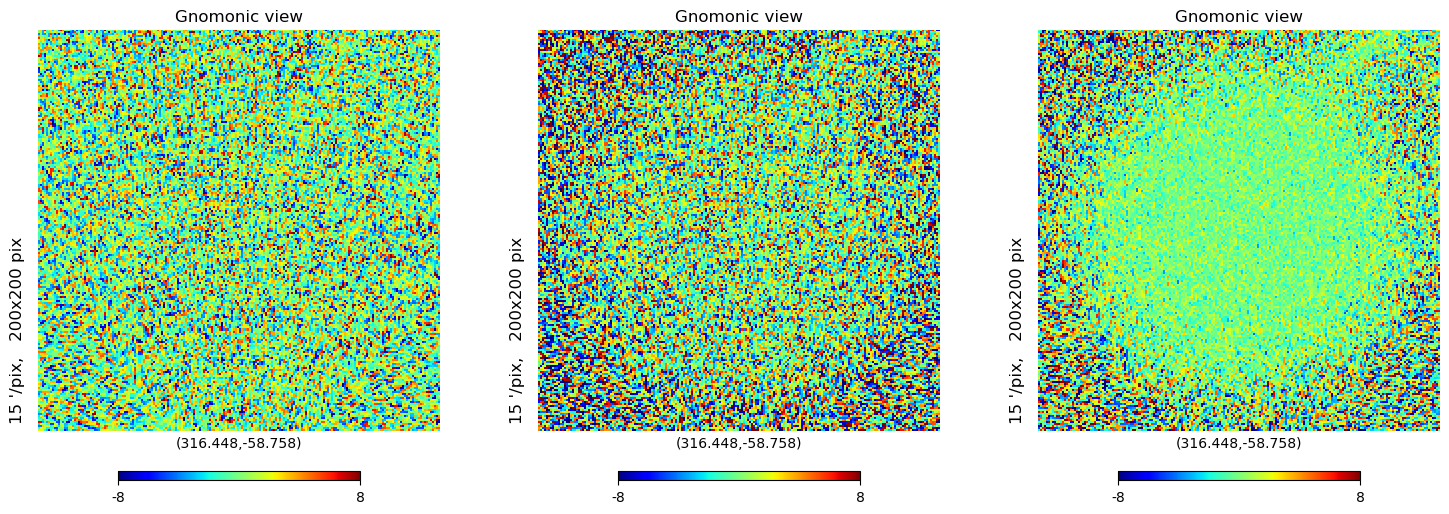

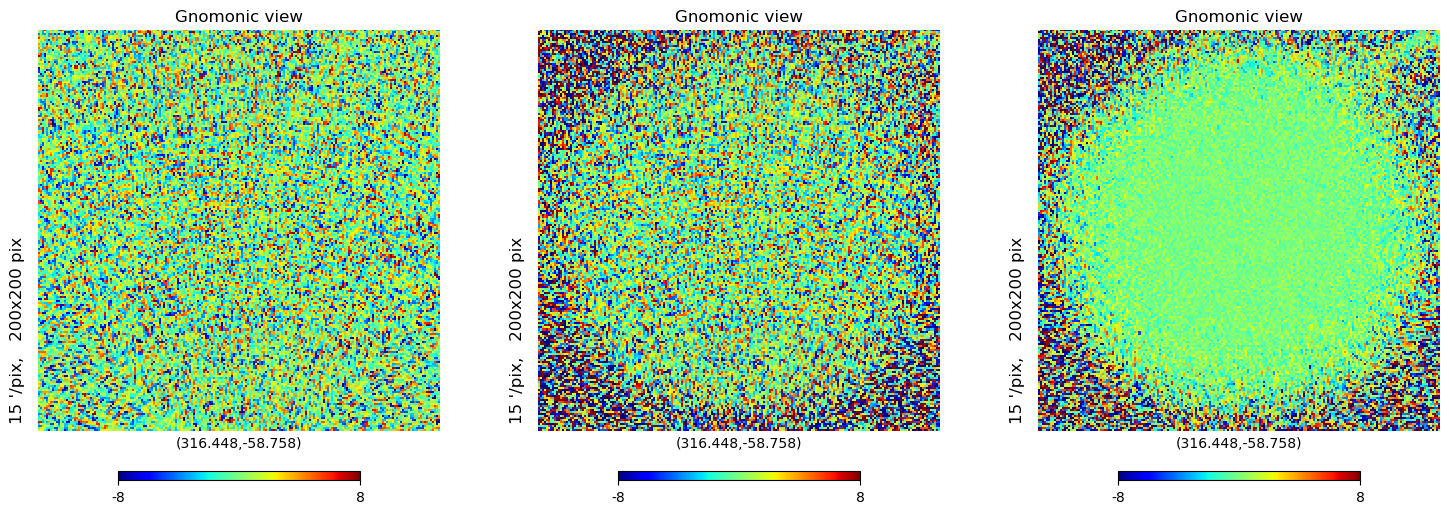

In [91]:
plt.figure(figsize=(15, 5))

res = 15
r = 8
istk = 1

hp.gnomview(cmb[0, :, istk], cmap='jet', rot=center, reso=res, sub=(1, 3, 1), min=-8, max=8)
hp.gnomview(solution['x'][0, :, istk], cmap='jet', rot=center, reso=res, sub=(1, 3, 2), min=-8, max=8)
hp.gnomview(cmb[0, :, istk]-solution['x'][0, :, istk], cmap='jet', rot=center, reso=res, sub=(1, 3, 3), min=-r, max=r)

plt.show()

plt.figure(figsize=(15, 5))

hp.gnomview(cmb[1, :, istk], cmap='jet', rot=center, reso=res, sub=(1, 3, 1), min=-8, max=8)
hp.gnomview(solution['x'][1, :, istk], cmap='jet', rot=center, reso=res, sub=(1, 3, 2), min=-8, max=8)
hp.gnomview(cmb[1, :, istk]-solution['x'][1, :, istk], cmap='jet', rot=center, reso=res, sub=(1, 3, 3), min=-r, max=r)

plt.show()